## Priority Sweeping
---
<img style="float:left" src="ps.png" alt="drawing" width="600"/>
> Only an update along a transition into the state just prior to the goal, or from it, will change any values. It is natural to prioritize the updates according to a measure of their `urgency`, and perform them in order of priority. This is the idea behind `prioritized sweeping`. A queue is maintained of every state–action pair whose estimated value would change nontrivially if updated, prioritized by the size of the change.

In [110]:
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt

In [6]:
ROWS = 6
COLS = 9
S = (2, 0)
G = (0, 8)
BLOCKS = [(1, 2), (2, 2), (3, 2), (0, 7), (1, 7), (2, 7), (4, 5)]
ACTIONS = ["left", "up", "right", "down"]

In [7]:
class Maze:
    
    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.start = S
        self.goal = G
        self.blocks = BLOCKS
        self.state = S
        self.end = False
        # init maze
        self.maze = np.zeros((self.rows, self.cols))
        for b in self.blocks:
            self.maze[b] = -1
            
    def nxtPosition(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1
        
        if (r >= 0 and r <= self.rows-1) and (c >= 0 and c <= self.cols-1):
            if (r, c) not in self.blocks:
                self.state = (r, c)
        return self.state
    
    def giveReward(self):
        if self.state == self.goal:
            self.end = True
            return 1
        else:
            return 0
        
    def showMaze(self):
        self.maze[self.state] = 1
        for i in range(0, self.rows):
            print('-------------------------------------')
            out = '| '
            for j in range(0, self.cols):
                if self.maze[i, j] == 1:
                    token = '*'
                if self.maze[i, j] == -1:
                    token = 'z'
                if self.maze[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-------------------------------------')

In [115]:
class PriorityAgent:

    def __init__(self, exp_rate=0.3, lr=0.1, n_steps=5, episodes=1, theta=0):
        self.maze = Maze()
        self.state = S
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr

        self.steps = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []

        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0

        # for priority sweeping
        self.theta = theta
        self.queue = PriorityQueue()
        self.predecessors = {}  # nxtState -> list[(curState, Action)...]

    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action

    def reset(self):
        self.maze = Maze()
        self.state = S
        self.state_actions = []

    def play(self):
        for ep in range(self.episodes):
            while not self.maze.end:

                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtPosition(action)
                reward = self.maze.giveReward()

                # update priority queue
                tmp_diff = reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action]
                if tmp_diff > self.theta:
                    self.queue.put((-tmp_diff, (self.state, action)))  # -diff -> (state, action) pop the smallest

                # update model & predecessors
                if self.state not in self.model.keys():
                    self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)
                if nxtState not in self.predecessors.keys():
                    self.predecessors[nxtState] = [(self.state, action)]
                else:
                    self.predecessors[nxtState].append((self.state, action))
                self.state = nxtState

                # loop n times to randomly update Q-value
                for _ in range(self.steps):
                    if self.queue.empty():
                        break
                    _state, _action = self.queue.get()[1]
                    _reward, _nxtState = self.model[_state][_action]
                    self.Q_values[_state][_action] += self.lr * (_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])

                    # loop for all state, action predicted lead to _state
                    if _state not in self.predecessors.keys():
                        continue
                    pre_state_action_list = self.predecessors[_state]

                    for (pre_state, pre_action) in pre_state_action_list:
                        pre_reward, _ = self.model[pre_state][pre_action]
                        pre_tmp_diff = pre_reward + np.max(list(self.Q_values[_state].values())) - self.Q_values[pre_state][pre_action]
                        if pre_tmp_diff > self.theta:
                            self.queue.put((-pre_tmp_diff, (pre_state, pre_action)))
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()

In [101]:
N_EPISODES = 50

### Comparing

In [107]:
import DynaMaze

In [112]:
agent = PriorityAgent(n_steps=5, episodes=N_EPISODES)
agent.play()

steps_episode_pa = agent.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [113]:
agent = DynaMaze.DynaAgent(n_steps=5, episodes=N_EPISODES)
agent.play()

steps_episode_da = agent.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


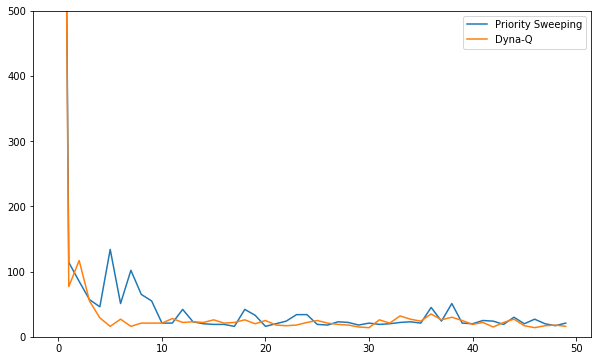

In [114]:
plt.figure(figsize=[10, 6])

plt.ylim(0, 500)
plt.plot(range(N_EPISODES), steps_episode_pa, label="Priority Sweeping")
plt.plot(range(N_EPISODES), steps_episode_da, label="Dyna-Q")

plt.legend()